# DNA RL: Crossover based optimization algorithm

Importing Libraries

In [1]:
import dna_env
import a2c
import torch
import variable as v
from tqdm import tqdm
from train_session import TrainSession
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np

Initializing Environment

In [2]:
sequence_length = 36
state_representation = 'latent'
render = True
action_constraints = {'co_length': (10, 12), 
                      'opt_start_point': (-1, 36),
                      'co_start_point': (-1, 36)}
early_stop_reward = {'reward_low_threshold': -1,
                     'reward_high_threshold': .9, 
                     'patience': 200}
env = dna_env.DnaRLEnv(action_constraints, early_stop_reward, sequence_length=sequence_length,
                      state_representation=state_representation)
env.reset()
train_session = None

In [3]:
seed = 23
state_dim = env.get_state_dim()
action_dim = env.get_action_dim()
print(f"state dim: {state_dim}")
print(f"action dim: {action_dim}")

state dim: (400,)
action dim: (3, 36)


Creating our agent

In [4]:
critic_init = {
    'seed': seed,
    'action_dim': action_dim[0],
    'state_representation': state_representation,
    'network': {
        'i_size': state_dim[0],
        'l1_size': 200,
        'l2_size': 100,
        'l3_size': 20
               },
    'optimizer': {
        'lr': 1e-5
    }
}
actor_init = {
    'entropy_learning_rate': 0.1,
    'seed': seed,
    'state_representation': state_representation,
    'action_dim': action_dim[0],
    'network': {
        'i_size': state_dim[0], 
        'l1_size': 200,        
        'hidden_size': 50, 
        'o_size': sequence_length
               },
    'optimizer': {
        'lr': 1e-5
    }
}
a2c_init = {
    'actor_type': 'actor_rnn',
    'seed': seed,
    'discount_factor': .99, 
    'state_dim': state_dim, 
    'action_space': 3, 
    'actor': actor_init, 
    'critic': critic_init
}

In [135]:
if not train_session:
    print('Train Session reset')
    train_session = TrainSession({}, env, seed)

In [136]:
agents_created = {
    'a2c_agent': a2c.A2C(a2c_init)
}
manual_agent_names = train_session.append_agents(agents_created, overwrite=True)

In [137]:
all_agent_names = train_session.agents.keys()
s = '\n- '.join(all_agent_names)
print(f"All Agents: \n- {s}")

All Agents: 
- a2c_agent


In [138]:
#train_session.load_model('a2c_agent', suffix='0710')

In [141]:
n_episode = 20
t_max_per_episode = 200
graphical = False

In [142]:
train_session.train(n_episode=n_episode, t_max_per_episode=t_max_per_episode,
                    graphical=graphical, agent_subset=manual_agent_names)


100%|██████████| 20/20 [01:38<00:00,  4.91s/it]


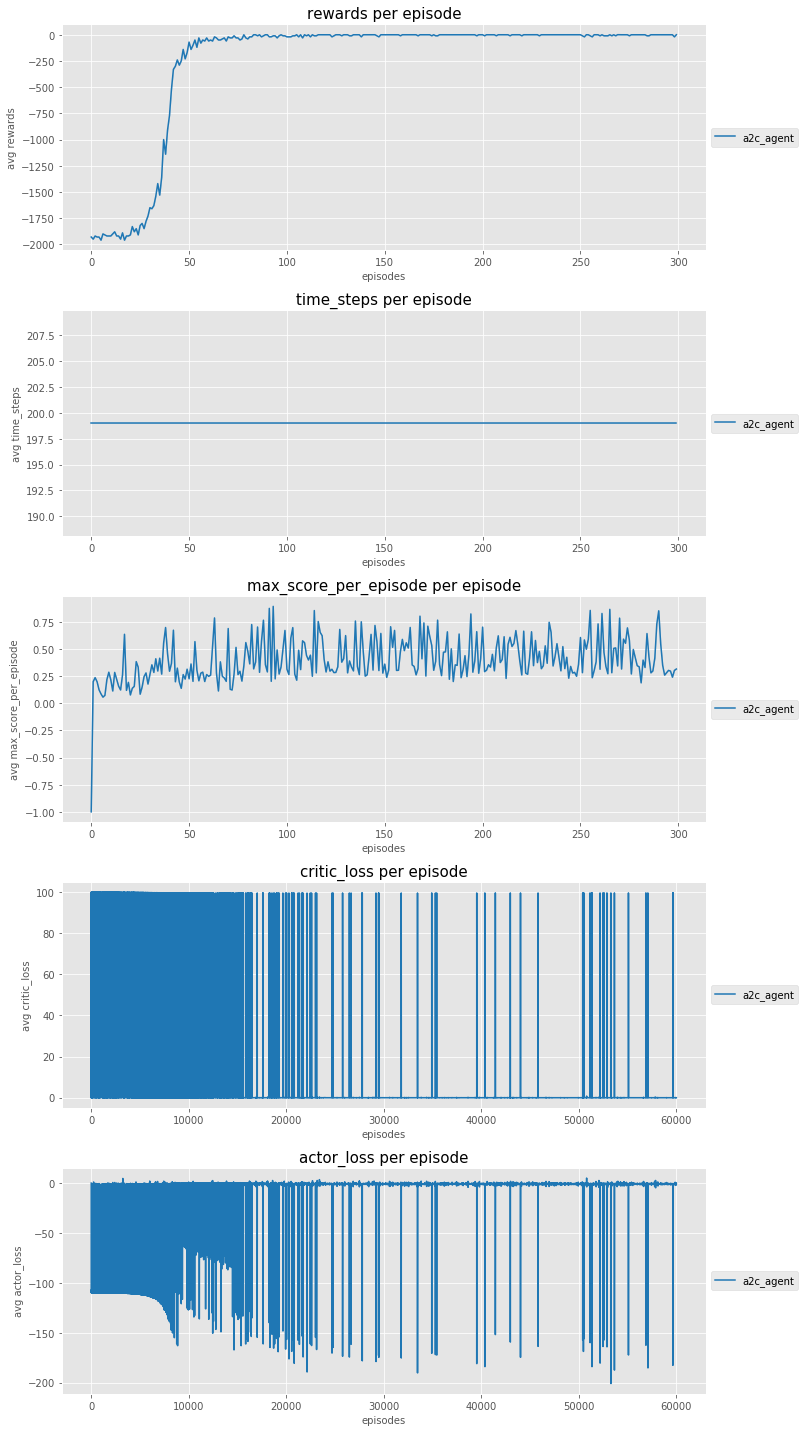

In [14]:
train_session.plot_results(window=1, agent_subset=manual_agent_names)

In [114]:
train_session

NameError: name 'train_session' is not defined

In [49]:
states = list()
for _ in range(10000):
    states.append(env.reset())
states_t = utils.to_tensor(states)

In [59]:
a = train_session.agents["a2c_agent"].actor.rnn_forward(states_t).mean(dim=1)[0].detach().cpu().numpy()

<BarContainer object of 36 artists>

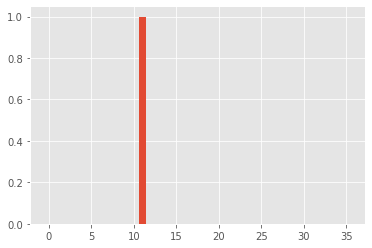

In [63]:
plt.bar(range(len(a)), a)

In [36]:
train_session.save_model(suffix='0708-3')

In [13]:
max(train_session.reward_per_time_step["a2c_agent"])

0.7286676168441772

In [27]:
np.ma.apply_along_axis(np.ma.masked_not_equal(train_session.reward_per_time_step["a2c_agent"], -1.0))

TypeError: apply_along_axis() missing 2 required positional arguments: 'axis' and 'arr'

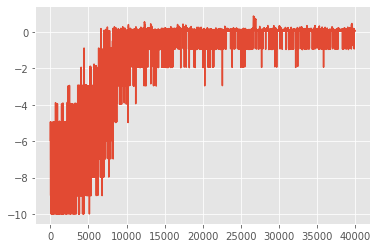

In [10]:
import numpy as np
train_session.reward_per_time_step["a2c_agent"] = np.ma.masked_not_equal(train_session.reward_per_time_step["a2c_agent"], -1.0)
series_mvg = utils.rolling_window(train_session.reward_per_time_step["a2c_agent"], window=10)
series_mvg_avg = np.mean(series_mvg, axis=1)
plt.plot(range(len(series_mvg_avg)), series_mvg_avg)

In [37]:
train_session.agents["a2c_agent"].critic(torch.rand(1, 400).cuda())

tensor([[-0.0450]], device='cuda:0', grad_fn=<AddmmBackward>)

In [25]:
state = env.reset()

In [13]:
(1, ) + state.shape

(1, 400)

In [10]:
a = torch.tensor([11, 23,  3], device=v.device)

In [13]:
a.cpu().numpy()

array([11, 23,  3])

In [17]:
a.prod()

tensor(759, device='cuda:0')

In [10]:
import utils

In [16]:
utils.to_tensor([[float(3)]])


tensor([[3.]], device='cuda:0')

In [61]:
torch.save(train_session.agents["a2c_agent"].critic.state_dict(), "/home/benoit/Documents/work/RL_DNA/saved_model/a2c_agent_critic_1.pth")

In [62]:
torch.save(train_session.agents["a2c_agent"].actor.state_dict(), "/home/benoit/Documents/work/RL_DNA/saved_model/a2c_agent_actor_1.pth")

In [36]:
max([.9, .8])

0.9

In [2]:
import torch

In [35]:
sequence_length = 36
render = True
action_constraints = {'co_length': (10, 12), 
                      'opt_start_point': (-1, 36),
                      'co_start_point': (-1, 36)}
early_stop_reward = {'reward_low_threshold': -1,
                     'reward_high_threshold': .9, 
                     'patience': 200}
env_raw = dna_env.DnaRLEnv(action_constraints, early_stop_reward, 
                           sequence_length=sequence_length, 
                           state_representation='raw')

In [36]:
s = env_raw.reset()

In [37]:
s_t = utils.to_tensor(s).view((1, ) + s.shape)

In [38]:
cp = torch.nn.ConstantPad1d(15 // 2, 0.25)
m = torch.nn.Conv1d(4, 400, 15, stride=2).cuda()
mp = torch.nn.AdaptiveMaxPool1d(1)

In [39]:
mp(m(cp(s_t))).squeeze(dim=2).shape

torch.Size([1, 400])

In [40]:
train_session.agents["a2c_agent"].critic(s_t)

torch.Size([1, 4, 72])


RuntimeError: size mismatch, m1: [4 x 72], m2: [400 x 200] at /opt/conda/conda-bld/pytorch_1587428266983/work/aten/src/THC/generic/THCTensorMathBlas.cu:283

In [7]:
action = np.array([1, 35, 0])
co_length, opt_start_point, co_start_point = action
opt_seq = np.array([0, 1, 0, 2, 2, 1, 0, 3, 3, 1, 0, 3, 2, 1, 3, 2, 0, 3, 
                    1, 0, 3, 1, 2, 3, 0, 0, 3, 1, 2, 1, 2, 1, 1, 3, 2, 0])
next_opt_seq = np.array([0, 1, 0, 2, 2, 1, 0, 3, 3, 1, 0, 3, 2, 1, 3, 2, 0, 3, 
                    1, 0, 3, 1, 2, 3, 0, 0, 3, 1, 2, 1, 2, 1, 1, 3, 2, 2])

co_seq = np.array([2, 1, 3, 3, 1, 3, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 3, 3, 0, 1, 2, 2,
                   2, 3, 0, 2, 2, 1, 3, 0, 2, 3, 0, 1, 0, 0])
next_co_seq = np.array([0, 1, 3, 3, 1, 3, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 3, 3, 0, 1, 2, 2,
                   2, 3, 0, 2, 2, 1, 3, 0, 2, 3, 0, 1, 0, 0])

In [8]:
env.cross_over_unitary_test(action, opt_seq, co_seq, next_opt_seq, next_co_seq)

1
[0 1 0 2 2 1 0 3 3 1 0 3 2 1 3 2 0 3 1 0 3 1 2 3 0 0 3 1 2 1 2 1 1 3 2 2]
[0 1 3 3 1 3 0 2 2 2 0 2 2 2 0 0 3 3 0 1 2 2 2 3 0 2 2 1 3 0 2 3 0 1 0 0]


True

In [11]:
action = np.array([34, 4, 3])
co_length, opt_start_point, co_start_point = action

In [12]:
min(co_length, (36) - max(opt_start_point, co_start_point))

32

In [13]:
co_seq[4: 4+32]

array([2, 3, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 3, 3, 0, 1, 2, 2, 2, 3, 0, 2,
       2, 1, 3, 0, 2, 3, 0, 1, 0, 0])

In [14]:
co_seq[36]

IndexError: index 36 is out of bounds for axis 0 with size 36

In [28]:
l.append(action.tolist() + [1])

In [29]:
l

[[1, 35, 0], [1, 35, 0], None, None, [1, 35, 0, 1]]

In [15]:
env.actions_history

[[11, 23, 3, True],
 [13, 4, 14, False],
 [18, 27, 35, False],
 [30, 25, 35, False],
 [14, 16, 10, False],
 [33, 1, 7, False],
 [7, 23, 1, False],
 [11, 4, 9, True],
 [31, 32, 0, False],
 [31, 4, 28, False],
 [18, 23, 29, False],
 [28, 27, 31, False],
 [23, 32, 0, False],
 [1, 11, 23, False],
 [12, 22, 24, False],
 [33, 28, 4, False],
 [5, 12, 25, False],
 [21, 18, 20, False],
 [15, 34, 13, False],
 [31, 9, 30, False],
 [35, 33, 14, False],
 [13, 29, 13, False],
 [25, 32, 3, False],
 [9, 0, 4, False],
 [4, 24, 11, False],
 [9, 26, 8, False],
 [29, 29, 0, False],
 [31, 14, 30, False],
 [12, 17, 10, False],
 [23, 33, 35, False],
 [5, 29, 7, False],
 [21, 1, 27, False],
 [20, 16, 1, False],
 [16, 8, 2, False],
 [24, 21, 26, False],
 [21, 34, 2, False],
 [17, 19, 35, False],
 [14, 31, 7, False],
 [1, 15, 2, False],
 [31, 28, 31, False],
 [17, 14, 32, False],
 [29, 19, 20, False],
 [13, 5, 25, False],
 [18, 17, 26, False],
 [12, 20, 24, False],
 [31, 7, 26, False],
 [22, 6, 8, False],
 [21,

In [25]:
import pandas as pd

In [50]:
pd.DataFrame(a_h).value_counts(sort=False).plot(kind='bar')

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [16]:
a_h = np.array(env.actions_history)

In [21]:
a_h[:, 3].sum()/len(a_h)

0.8730833333333333

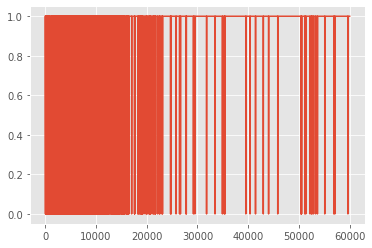

In [19]:
plt.plot(range(len(a_h)), a_h[:, 3])

In [51]:
d = pd.DataFrame(a_h)

In [54]:
for c in d.columns:
    print(c)

0
1
2
3


In [15]:
import torch
import numpy as np

In [16]:
p = torch.tensor([0.1, 0.3, 0.6])
d = torch.distributions.Categorical(probs=p)

In [17]:
actions = list()
for _ in range(3):
    a = d.sample()
    actions.append(a)

In [18]:
torch.tensor(actions).cuda()

tensor([2, 0, 0], device='cuda:0')

In [21]:
import utils
ab = utils.to_tensor(actions).long()

In [23]:
ab[0]

tensor(2, device='cuda:0')

In [1]:
import os

In [2]:
data_path = os.environ['PDBX_UBC'] + '/data/GA/Raluca/Combined_Max_Myc_Mad_Mad_r_log.xlsx'

In [3]:
data_path

'/home/benoit/Documents/work/PDBX_UBC/data/GA/Raluca/Combined_Max_Myc_Mad_Mad_r_log.xlsx'

In [4]:
import pandas as pd

In [43]:
pd.read_excel(data_path, usecols=['Sequence']).values[0][0].

'CCCACCCGCCGCGCCCACGCGTGCCGCGGTCGCTTG'

In [68]:
import numpy as np

In [57]:
a = pd.read_excel(data_path)['Sequence'].values

In [76]:
a

array(['CCCACCCGCCGCGCCCACGCGTGCCGCGGTCGCTTG',
       'CGGACCCTGGCTCTCCACGCGCCTCCGACATGGCGG',
       'GAAGAGGACGGCATGCATGCGGACCCCGTCCACCAC', ...,
       'AGGGACTAGATTTTTTCTATTTTCTACCTAACAGGA',
       'ACAAGATACAGAAAGGTGGTTTGCCATTTTCTAGCA',
       'GTTCTTTGTCAGCGATGTCCCCAACAATGGGCAGAA'], dtype=object)

In [112]:
li = iter([np.vectorize(d.get)(list(sequence)) for sequence in a[:3]])

In [111]:
try:
    print(next(li))
except StopIteration:
    print("lol")

lol


In [71]:
np.vectorize(d.get)(list(a[0]))

array(None, dtype=object)

In [ ]:
a.apply(lambda s: )

In [46]:
s1 = 'CCCACCCGCCGCGCCCACGCGTGCCGCGGTCGCTTG'
d = {'A': 0, 'T': 1, 'G': 2, 'C': 3}

In [56]:
for key in d.keys():
    s1.replace(key, d[key])

TypeError: replace() argument 2 must be str, not int

In [55]:
s1

'CCCACCCGCCGCGCCCACGCGTGCCGCGGTCGCTTG'

In [54]:
next(b)

'ATGCAGGCACTTAAGCACGTGGACTACCACCGACAG'

In [33]:
c = iter([1, 2, 3, 4])

In [40]:
c.

AttributeError: 'list_iterator' object has no attribute 'empty'

In [5]:
import torch

In [8]:
a = torch.randn(5, 4)

In [10]:
a[2:4]

tensor([[-0.8476,  0.0168,  0.5648, -1.6220],
        [-0.5868,  0.3167,  1.5650,  0.0653]])